In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
from functools import partial

import jVMC
import jax 
import jax.numpy as jnp 
import jax.random as jrnd
import matplotlib.pyplot as plt
from flax import linen as nn
tReal = jnp.float64
tComplex = jnp.complex128
import numpy as np


2024-10-22 16:09:50.819173: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
class net_coherent_state():
    #L: int 
    #LDimHilbert: int 
    #x: jax.Array
    #logProbFactor: float = 0.5
    #dtype: type = tReal
    def __init__(self,L,LDimHilbert,x,logProbFactor=0.5,dtype=tReal,temperature = 1.):
        self.L = L
        self.LDimHilbert = LDimHilbert
        self.logProbFactor = logProbFactor
        self.dtype = dtype
        self.x = x

        self.temperature = temperature
        self.setup()
    def setup(self):
        self.ldim = self.LDimHilbert
        self.ln_x = jnp.log(self.x)
        self.prelnExp = jnp.sum(-jnp.abs(self.x)**2/2)
        self.probs = self.prelnExp + jnp.arange(self.ldim)[None,:] * self.ln_x[:,None]  - 0.5*jnp.log(jax.scipy.special.gamma(jnp.arange(1,self.ldim+1)))[None,:]
        self.probs *= 2
        self.probs = self.probs
        """def __init__(self,L,LDimHilbert,x,logProbFactor=0.5):
            self.L = L
            self.ldim = LDimHilbert
            self.x = x
            self.ln_x = jnp.log(x)
            self.prelnExp = jnp.sum(-jnp.abs(self.x)**2/2)
            self.probs = self.prelnExp + jnp.arange(self.ldim)[:,None] * self.ln_x[None,:]  - 0.5*jnp.log(jax.scipy.special.gamma(jnp.arange(1,self.ldim+1)))[:,None]
            self.probs *= 2
            self.logProbFactor = logProbFactor
        """
    def __call__(self, s: jax.Array, output_state: bool = False) -> jax.Array:
        # the helper method allows to use nn.jit with static_argnames
        return self.forward_with_state(s, output_state)

    #@partial(nn.jit, static_argnums=2)
    def forward_with_state(self, s: jax.Array, output_state: bool = False) -> jax.Array:
        return (jnp.take_along_axis(self.probs, jnp.expand_dims(s, -1), axis=-1)
                                .sum(axis=-2)
                                .squeeze(-1) ) * (1 if output_state else self.logProbFactor)
                   
            #self.prelnExp + jnp.sum( s * self.ln_x  - 0.5*jnp.log(jax.scipy.special.factorial(s)))
    def apply(self,para,s,*args,**kwargs):
        if "method" in kwargs:
            print(kwargs["method"])
            print(para,args)
            return self.sample(s,*args)
        return self(s)
    
    def sample(self,numSamples: int, key) -> jax.Array:
        def generate_sample(key):
            #key = jrnd.split(key, 1self.L)


            logits =self.probs 
            choice = jrnd.categorical(key, logits.T.real/self.temperature,axis=0)
            return choice
            _, s = self._scanning_fn((jnp.expand_dims(choice,0),carry),key[1:])
            state = jnp.concatenate([jnp.expand_dims(choice,0),s])
            return jnp.take_along_axis(self.patch_states,state[:,None],axis=0).flatten()

        # get the samples
        keys = jrnd.split(key, numSamples)
        return jax.vmap(generate_sample)(keys)
"""
class sampler_coherent:

    def __init__(self,L,x,numSamples=100)
        self.L = L
        self.x = x 
        self.numSamples = numSamples
    def sample(self,numSamples=None,**kwargs):
        
        configs = 
        coeffs = 
        return configs, coeffs, jnp.ones(configs.shape[:2]) / jnp.prod(jnp.asarray(configs.shape[:2]))
"""

'\nclass sampler_coherent:\n\n    def __init__(self,L,x,numSamples=100)\n        self.L = L\n        self.x = x \n        self.numSamples = numSamples\n    def sample(self,numSamples=None,**kwargs):\n        \n        configs = \n        coeffs = \n        return configs, coeffs, jnp.ones(configs.shape[:2]) / jnp.prod(jnp.asarray(configs.shape[:2]))\n'

In [3]:
L = 10
ldim = 11
x = jnp.array([1.5+0.1j]+[1]*(L-1),dtype=complex)
coh =net_coherent_state(L,ldim,x)
psi_coh = jVMC.vqs.NQS(coh)
psi_coh.initialized = True
testFock = jnp.array([[[1]*L]])
coh(testFock[0,0]),coh.probs.shape

(Array(-55.89231759+0.06656816j, dtype=complex128), (10, 11))

In [4]:
key = jrnd.PRNGKey(11)
coh.sample(13,key).shape

(13, 10)

In [5]:
psi_coh(testFock)

Array([[-55.89231759+0.06656816j]], dtype=complex128)

In [6]:
key2 = jrnd.split(key, 1)
print(key2)

logits =coh.probs 

choice = jrnd.categorical(key2, logits.real,axis=1)
choice

[[3947986621 4020105687]]


Array([1, 1, 1, 2, 3, 1, 1, 0, 4, 0], dtype=int64)

In [7]:
repeats = 20
numSamp = 4*1024
key2 = jrnd.PRNGKey(1)
y = np.zeros((L,ldim),dtype=float)
for i in range(repeats):
    key2 = jrnd.split(key2,2)[0]
    s = coh.sample(numSamp,key2)
    print(jnp.array(([coh(x) for x in s])))
    print(s.shape)
    p = np.array([1./numSamp]*numSamp)
    y += np.array([np.histogram(x,ldim,range=(0-0.5,ldim-0.5),weights=p,density=True)[0] for x in  s.T])


[-57.01255329+0.19970449j -57.13477092+0.06656816j
 -56.99314718+0.j         ... -57.00190743+0.33284082j
 -58.54047138+0.26627266j -57.56185943+0.19970449j]
(4096, 10)
[-59.13148024+0.j         -57.48134451+0.06656816j
 -58.57152824+0.13313633j ... -57.42023569+0.13313633j
 -56.87092955+0.13313633j -57.8279181 +0.06656816j]
(4096, 10)
[-57.76680928+0.13313633j -57.29801806+0.26627266j
 -58.72379783+0.06656816j ... -60.42439652+0.06656816j
 -58.40195101+0.46597715j -58.52106528+0.06656816j]
(4096, 10)
[-56.95144447+0.26627266j -58.37722424+0.06656816j
 -56.93203836+0.06656816j ... -56.23889118+0.06656816j
 -56.58546477+0.06656816j -56.17778237+0.13313633j]
(4096, 10)
[-56.23889118+0.06656816j -57.50075061+0.26627266j
 -56.72708851+0.13313633j ... -56.99314718+0.j
 -56.95144447+0.26627266j -57.56407673+0.13313633j]
(4096, 10)
[-55.83120878+0.13313633j -57.56185943+0.19970449j
 -57.42023569+0.13313633j ... -55.97283251+0.19970449j
 -56.52435596+0.13313633j -59.13148024+0.j        ]
(4096

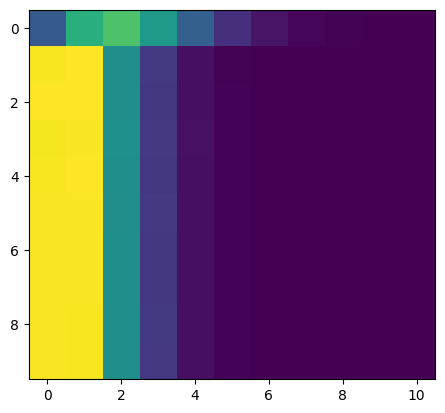

In [8]:
plt.imshow(y)


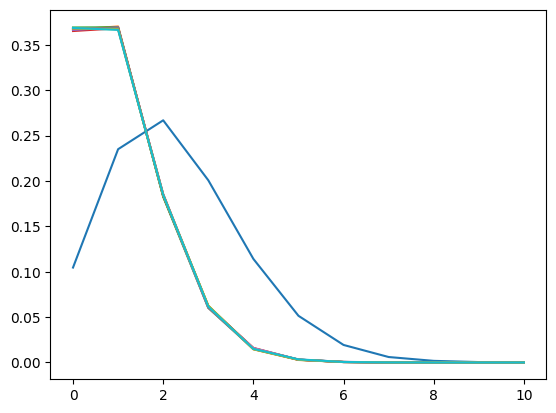

In [9]:
plt.plot(y.T/np.sum(y.T,axis=0))



/rz_cloud/richter/stm58133/condaEnv/jvmc_gpu/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/rz_cloud/richter/stm58133/condaEnv/jvmc_gpu/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(10, 11)

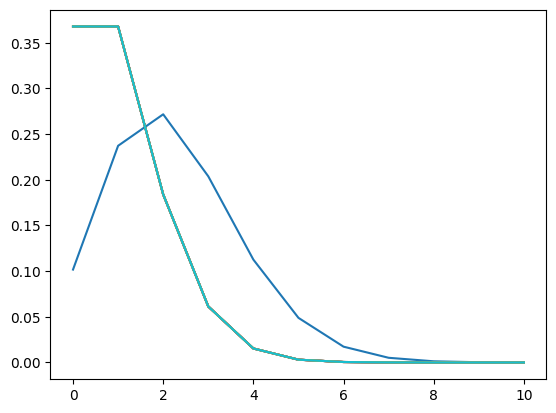

In [10]:
plt.plot(np.exp(coh.probs).T/np.sum(np.exp(coh.probs).T,axis=0))
coh.probs.shape

In [11]:
##############################################
# J Rigo
# rigojonas@gmail.com
# Regensburg 20/11/2023
# Implementation of https://arxiv.org/abs/2305.14294
# by Sinibaldi et al. 
##############################################

import jax
from jax import jit, vmap, grad#, partial
import jax.numpy as jnp

import jVMC.global_defs as global_defs
import jVMC.mpi_wrapper as mpi
from jVMC.stats import SampledObs
import jVMC.operator as op


import functools
import itertools


class _InfidelityP(op.Operator):
    """This class provides functionality to compute ratios of neural quantum states :math:`\\frac{\\chi(s)}{\\psi(s)}`. More specifically it implements

        :math:`\sum_{s}\\delta_{ss'}\\frac{\\chi(s)}{\\psi(s')}` 


    Initializer arguments:
        None
    """   

    def compile(self):

        def map_function(s, *args,):

            sp = s.copy()
            configShape = sp.shape

            matEl = jnp.array([1.], dtype=global_defs.tCpx)

            return sp.reshape(1,*configShape), matEl

        return map_function

#########################################################

class Infidelity(op.Operator):
    """This class provides functionality to compute and optimize the infidelity given a target wave function :math:`\chi(s')` and a trial wave function :math:`\psi(s)`.

    The infidelity for two pure states is defined as
    
        :math:`\\mathcal{I} = 1 - \\sum_s \\Psi(s)\\frac{\\chi(s)}{\\psi(s)}\\times\\sum_{s'} \\Chi(s')\\frac{\\psi(s')}{\\chi(s')} = 1 - \\mathbb{E}_\\Psi\\frac{\\chi(s)}{\\psi(s)}\\times\\mathbb{E}_\\Chi\\frac{\\psi(s')}{\\chi(s')}`

    where we have introduced the short-hand for the Born distribution for the target and trial wave function
    
        :math:`\\Psi(s) = \\frac{\\psi(s)}{\\sum_s|\\psi(s)|^2} \\qquad \\Chi(s') = \\frac{\\chi(s')}{\\sum_{s'}|\\chi(s')|^2}` 

    With the local infidelity 
    
        :math:`F^\\psi_{\\rm loc}(s) = \\frac{\\chi(s)}{\\psi(s)}\\times\\sum_{s'} \\qquad F^\\chi_{\\rm loc}(s') = \\frac{\\psi(s')}{\\chi(s')}`

    the infidelity can be expressed as 

        :math:`\\mathcal{I} = 1 - \\mathbb{E}_\\Psi F^\\psi_{\\rm loc}(s)\\times\mathbb{E}_\\Chi F^\\chi_{\\rm loc}(s')`

    In this class the :math:`F^\\psi` and :math:`F^\\chi` are computed separately, such that :math:`F^\\chi` can be computed once and reused for any :math:`\\psi`.


    Initializer arguments:

        * ``chi``: Target wave function as neural quantum state.
        * ``chiSampler``: Sampler initialized with ``chi``
    """
    
    def __init__(self,coh,psi_coh,numSamp,key):

        #########################################################

        # save the target wave funciton internally
        self.chi = psi_coh
        self.numSamp = numSamp
        # save the target sampler internally
        #self.chiSampler = chiSampler
        samples = coh.sample(numSamp,key)
        self.chi_s = jnp.array([samples])

        self.chi_logChi = self.chi(self.chi_s)# jnp.array([[self.chi(s) for s in self.chi_s[0]]])
        self.chi_p = jnp.array([[[1./numSamp]*numSamp]])
        ######## get samples ########
        #self.chi_s, self.chi_logChi, self.chi_p = self.chiSampler.sample()
        # get the Infidelity to global scope
        self._InfidelityP = _InfidelityP()
        # needs to be called for initalization
        _, _ = self._InfidelityP.get_s_primes(self.chi_s)
        # check if was called
        self._FP_loc_check = False

        super().__init__()  # Constructor of base class Operator has to be called!
        
    
    def get_FP_loc(self, psi):
        """ Compute :math:`F^\\chi` given the target wave function :math:`\\chi` and trial wave function :math:`\\psi`.

        Arguments:
            * ``psi``: Neural quantum state.

        Returns:
            * :math:`F^\\chi_{\\rm loc}(s)` for each configuration :math:`s`.
            * :math:`F^\\chi`    
        """

        # confirm that the function was called
        self._FP_loc_check = True
        # get psi nqs amplitudes
        chi_logPsi = psi(self.chi_s)
        # compute F^\chi_loc
        self.chi_Floc = self._InfidelityP.get_O_loc_unbatched(self.chi_logChi,chi_logPsi)
        # compute F^chi
        self.Exp_chi_Floc = mpi.global_mean(self.chi_Floc,self.chi_p)
        return self.chi_Floc, self.Exp_chi_Floc
    
    
    def get_gradient(self, psi, psi_p,  corrections=False):
        """ Compute :math:`\\nabla\\mathcal{I}`

        The gradient is computed from almost exclusively internally stored quantities

            :mat:`2\\mathbb{E}_\\Psi\\big[ \\Re~ O_k(s)F^\\psi_{\\rm loc}(s)\\big] \\, F^\\chi-2\\mathbb{E}_\\Psi\\big[ \\Re~ O_k(\\sigma)\\big] \\, F^\\psi \\, F^\\chi`        

        where :math:`O_k(s)` is the log derivative of the trial wave function.

        Arguments:
            * ``psi``: Neural quantum state.
            * ``psi_p``: Born distribution :math:`\Psi(s)` evaluated at the samples
            * ``corrections``: Bool to include gradient correction

        Returns:
            * :math:`F^\\chi_{\\rm loc}(s)` for each configuration :math:`s`.
            * :math:`F^\\chi`    
        """

        # compute the gradient throught the covariance
        Opsi = psi.gradients(self._flatten_pmapd(self.sp))
        grads = SampledObs(Opsi, psi_p)
        Floc = SampledObs(self.psi_Floc, psi_p)
        grad = 2.*grads.covar(Floc)*self.Exp_chi_Floc

        # correction
        if corrections:
            chi_Fgrads = SampledObs(psi.gradients(self.chi_s).real * self.chi_Floc.reshape(*self.chi_Floc.shape,1).real, self.chi_p) 
            corr_grad_minus = chi_Fgrads.mean().real * mpi.global_mean(self.psi_Floc.real,psi_p)

            psi_Fgrads = SampledObs(Opsi.real * self.psi_Floc.reshape(*self.psi_Floc.shape,1), psi_p)
            corr_grad_plus = psi_Fgrads.mean().real * self.Exp_chi_Floc.real

            grad -= (- corr_grad_minus.reshape(grad.shape) + corr_grad_plus.reshape(grad.shape))

        return -1. * grad.real

    def compile(self):
        """This function computes ratios of neural quantum states :math:`\\frac{\\chi(s)}{\\psi(s)}`. More specifically it implements

            :math:`\sum_{s}\\delta_{ss'}\\frac{\\chi(s)}{\\psi(s')}` 


        Initializer arguments:
            None
        """   
        
        # check if get_FP_loc was called
        if not self._FP_loc_check:
            raise ValueError("get_FP_loc was not called")

        def map_function(s, *args,):

            sp = s.copy()
            configShape = sp.shape

            matEl = jnp.array([1.], dtype=global_defs.tCpx)

            return sp.reshape(1,*configShape), matEl

        return map_function


    def get_O_loc(self, samples, psi, logPsiS=None, *args):
        """Compute :math:`F^\\psi_{\\rm loc}(s)`.

        If the instance parameter ElocBatchSize is larger than 0 :math:`F^\\psi_{\\rm loc}(s)` is computed in a batch-wise manner
        to avoid out-of-memory issues.

        Arguments:
            * ``samples``: Sample of computational basis configurations :math:`s`.
            * ``psi``: Neural quantum state.
            * ``logPsiS``: Logarithmic amplitudes :math:`\\ln(\psi(s))`
            * ``*args``: Further positional arguments for the operator.

        Returns:
            :math::math:`F^\\psi_{\\rm loc}(s)` for each configuration :math:`s`.
        """

        if logPsiS is None:
            _ , _ = self.get_s_primes(samples, *args)
            logPsiS = psi(samples)

        if self.ElocBatchSize > 0:
            return self.get_O_loc_batched(samples, psi, logPsiS, self.ElocBatchSize, *args)
        else:
            return self.get_O_loc_unbatched(logPsiS)


    def get_O_loc_unbatched(self, logPsiS,logPsiSP=None):
        """Compute :math:`F^\\psi_{\\rm loc}(s)`.

        This member function assumes that ``get_s_primes(s)`` has been called before, as \
        internally stored matrix elements :math:`F^\\chi` are used.

        Computes :math:`F_{loc}(s)= F_\chi\\frac{\chi(s)}{\psi(s)}`, given the \
        logarithmic wave function amplitudes of the involved configurations :math:`\\ln(\psi(s))` \
        and :math:`\\ln\psi(s')`

        Arguments:
            * ``logPsiS``: Logarithmic amplitudes :math:`\\ln(\psi(s))`

        Returns:
            :math:`1 - F^\\psi_{\\rm loc}(s)F^\\chi` for each configuration :math:`s`.
        """

        self.psi_Floc = self._get_O_loc_pmapd(self.matEl, logPsiS, self.chi(self._flatten_pmapd(self.sp)))
        return 1. - self.psi_Floc * self.Exp_chi_Floc


    def get_O_loc_batched(self, samples, psi, logPsiS, batchSize, *args):
        """Compute :math:`F^\\psi_{\\rm loc}(s)` in batches.

        Computes :math:`F^\\psi_{\\rm loc}(s)=F^\\chi\\frac{\chi(s)}{\psi(s)}` in a batch-wise manner
        to avoid out-of-memory issues.

        Arguments:
            * ``samples``: Sample of computational basis configurations :math:`s`.
            * ``psi``: Neural quantum state.
            * ``logPsiS``: Logarithmic amplitudes :math:`\\ln(\psi(s))`
            * ``batchSize``: Batch size.
            * ``*args``: Further positional arguments for the operator.

        Returns:
            :math:`1 - F^\\psi_{\\rm loc}(s)F^\\chi` for each configuration :math:`s`.
        """

        Oloc = None

        numSamples = samples.shape[1]
        numBatches = numSamples // batchSize
        remainder = numSamples % batchSize

        # Minimize mismatch
        if remainder > 0:
            batchSize = numSamples // (numBatches+1)
            numBatches = numSamples // batchSize
            remainder = numSamples % batchSize

        for b in range(numBatches):

            batch = self._get_config_batch_pmapd(samples, b * batchSize, batchSize)
            logPsiSbatch = self._get_logPsi_batch_pmapd(logPsiS, b * batchSize, batchSize)

            # internalize the new batch
            sp, _ = self.get_s_primes(batch, *args)

            # modified the get_O_loc_unbatched function
            OlocBatch = self.get_O_loc_unbatched(logPsiSbatch)

            if Oloc is None:
                if OlocBatch.dtype == global_defs.tCpx:
                    Oloc = self._alloc_Oloc_cpx_pmapd(samples)
                else:
                    Oloc = self._alloc_Oloc_real_pmapd(samples)

            Oloc = self._insert_Oloc_batch_pmapd(Oloc, OlocBatch, b * batchSize)
        
        if remainder > 0:

            batch = self._get_config_batch_pmapd(samples, numBatches * batchSize, remainder)
            batch = global_defs.pmap_for_my_devices(expand_batch, static_broadcasted_argnums=(1,))(batch, batchSize)
            logPsiSbatch = self._get_logPsi_batch_pmapd(logPsiS, numBatches * batchSize, numSamples % batchSize)
            logPsiSbatch = global_defs.pmap_for_my_devices(expand_batch, static_broadcasted_argnums=(1,))(logPsiSbatch, batchSize)

            # internalize the new batch
            sp, _ = self.get_s_primes(batch, *args)

            # modified the get_O_loc_unbatched function
            OlocBatch = self.get_O_loc_unbatched(logPsiSbatch)
        
            OlocBatch = self._get_Oloc_slice_pmapd(OlocBatch, 0, remainder)

            Oloc = self._insert_Oloc_batch_pmapd(Oloc, OlocBatch, numBatches * batchSize)

        # saving F^\psi internalli
        self.psi_Floc = Oloc
        return 1. - self.psi_Floc * self.Exp_chi_Floc

# auxillary function
def expand_batch(batch, batchSize):
    outShape = list(batch.shape)
    outShape[0] = batchSize
    outp = jnp.zeros(tuple(outShape), dtype=batch.dtype)
    return outp.at[:batch.shape[0]].set(batch)


In [37]:
import optax
tReal
net = jVMC.nets.CpxRWKV_patched(L,ldim,1,hidden_size=16,num_layers=2,flag_phase=True,dtype=tReal)
psi = jVMC.vqs.NQS(net)

psiSampler = jVMC.sampler.MCSampler(psi, (L,), jrnd.PRNGKey(np.random.randint(1000000)))
    

myInf = Infidelity(coh,psi_coh,numSamp=numSamp,key=key)
learning_rate=1e-2
# create the optimizer
optimizer = optax.adamw(learning_rate=learning_rate)
# init optimizer
state = optimizer.init(psi.get_parameters())# test the compactified class

In [13]:
n_iter = 1000
s_infidelity_acc = np.zeros(n_iter)
for i in range(n_iter):
    if i%100 == 0: 
        print("Iteration %i"%(i))
        #myInf = Infidelity(coh,psi_coh,numSamp=numSamp,key=jrnd.PRNGKey(np.random.randint(1000)))

    # Set up sampler for psi
    ######## get infidelity ########
    chi_Floc, Exp_chi_Floc = myInf.get_FP_loc(psi)
    psi_s, psi_logPsi, psi_p = psiSampler.sample()
    _, _ = myInf.get_s_primes(psi_s)
    psi_Floc = myInf.get_O_loc_unbatched(psi_logPsi)
    I_mean = jVMC.mpi_wrapper.global_mean(psi_Floc,psi_p)
    s_infidelity_acc[i] = I_mean.real
    print("Infidelity: %.6f"%(I_mean.real))

    # get the gradients
    grad = myInf.get_gradient(psi,psi_p)

    # get the psi parameters
    psi_params = psi.get_parameters()

    # update optimiser state
    updates, state = optimizer.update(grad.reshape(psi_params.shape), state, psi_params)  # Update para?meters
    params = optax.apply_updates(psi_params, updates)
    # set paramters again
    psi.set_parameters(params)

Iteration 0
Infidelity: 0.999889
Infidelity: 0.999999
Infidelity: 0.999997
Infidelity: 0.999989
Infidelity: 0.999999
Infidelity: 0.999991
Infidelity: 0.999999
Infidelity: 0.999975
Infidelity: 0.999995
Infidelity: 0.999998
Infidelity: 1.000000
Infidelity: 0.999998
Infidelity: 0.999999
Infidelity: 0.999999
Infidelity: 0.999994
Infidelity: 0.999981
Infidelity: 0.999960
Infidelity: 0.989989
Infidelity: 0.999999
Infidelity: 0.999991
Infidelity: 0.998631
Infidelity: 0.999630
Infidelity: 0.999987
Infidelity: 1.000000
Infidelity: 0.999878
Infidelity: 0.999971
Infidelity: 0.996078
Infidelity: 0.999992
Infidelity: 0.999989
Infidelity: 0.999999
Infidelity: 0.999995
Infidelity: 1.000000
Infidelity: 0.999994
Infidelity: 0.999880
Infidelity: 0.999146
Infidelity: 0.999672
Infidelity: 0.999983
Infidelity: 0.999999
Infidelity: 0.999941
Infidelity: 0.999845
Infidelity: 0.999955
Infidelity: 0.999984
Infidelity: 0.999990
Infidelity: 0.999997
Infidelity: 0.999990
Infidelity: 0.999983
Infidelity: 0.999987
I

Text(0, 0.5, '$\\mathcal{I}$')

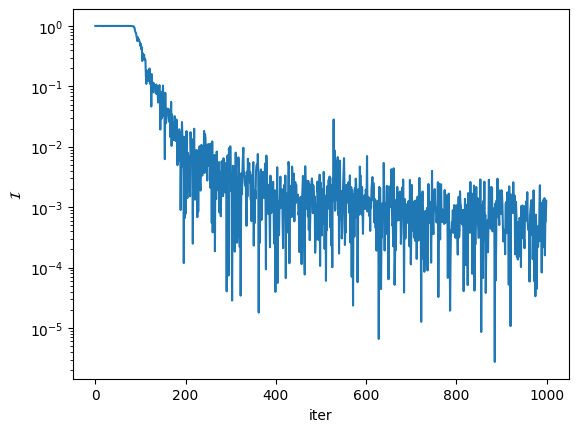

In [14]:
plt.plot(jnp.arange(n_iter),abs(s_infidelity_acc))
plt.yscale("log")
plt.xlabel("iter")
plt.ylabel("$\\mathcal{I}$")

In [38]:
copy_para = 1.* psi.get_parameters()


In [43]:

J = 1.
U = 1.
H = jVMC.operator.BoseHubbard_Hamiltonian1D(L,J,U,lDim=ldim)

tdvpEquation = jVMC.util.tdvp.TDVP(psiSampler,rhsPrefactor=1j,diagonalShift=0,
                                   makeReal='imag')
#tdvpEquation = jVMC.util.MinSR(psiSampler, pinvTol=1e-8,
#                                    diagonalShift=1,
#                                    makeReal='real')

timeRange = np.linspace(0,0.011,101)
dt = timeRange[1]-timeRange[0]
stepper = jVMC.util.stepper.Euler(timeStep=dt)
psi.set_parameters(copy_para*1.)
observables = {
    "energy": H,
}
obs = jVMC.util.measure(observables, psi, psiSampler)
data = []

data.append([0, obs["energy"]["mean"][0]])

print(obs["energy"])
print("dt",dt)
#psi.parameters

{'mean': Array([89.3375603], dtype=float64), 'variance': Array([2127.58670193], dtype=float64), 'MC_error': Array([4.61257705], dtype=float64)}
dt 0.00010999999999999999


In [44]:
for it,t in enumerate(timeRange[1:]):
    #print(psi.get_parameters())
    #print(psi.)
    #print(jnp.linalg.norm(psi.get_parameters()))
    #print(tdvpEquation(psi.get_parameters(), 0,hamiltonian= H,psi=psi, intStep=0))
    #print(jnp.linalg.norm(tdvpEquation(psi.get_parameters(), 0,hamiltonian= H,psi=psi, intStep=0)))

    dp, dt = stepper.step(0, tdvpEquation, psi.get_parameters(), hamiltonian=H, psi=psi)
    print(dp,dt)
    psi.set_parameters(dp.real)
    obs = jVMC.util.measure(observables, psi, psiSampler)
    data.append([t, obs["energy"]["mean"][0]])
    print(obs["energy"])



[ 2.42843944e-02  1.71609917e-02  1.26157796e-02 -4.89486072e-02
 -1.70043352e-01  3.28372787e-03  1.57883224e-03  4.82107284e-02
  3.38007753e-02  4.88875398e-02 -8.74759195e-02  1.07066945e-01
  1.39931061e-01 -6.12852640e-02 -1.39566914e-01  7.50024504e-02
  4.33837788e-03 -2.77920275e-02 -4.78990715e-03  5.50844827e-02
 -1.40630525e-02  1.27154326e-01 -8.13331593e-02  1.64958716e-01
  1.81058648e-02  6.31173393e-02  6.12627473e-03 -9.49275030e-02
  6.49445448e-02  2.43737042e-02 -3.76117559e-02 -1.66922658e-02
  7.41877795e-02 -2.48040650e-02 -3.26996016e-02  1.76145657e-01
  1.97659802e-02 -7.64309396e-02 -7.57342312e-03 -9.37096005e-02
 -1.23177590e-01  1.44327305e-01  3.17725922e-02  9.51414022e-03
 -1.28224140e-01 -6.15734642e-02 -2.50272906e-02 -1.55681092e-01
  1.49026477e-01  1.04332432e-01  5.72287009e-02  1.32182485e-02
  1.58928056e-01  1.45798107e-01 -3.86065590e-02 -1.38171222e-01
  8.84719232e-02  1.10467881e-02 -2.14236064e-02  4.63067871e-02
  1.78662497e-01  3.87439

KeyboardInterrupt: 

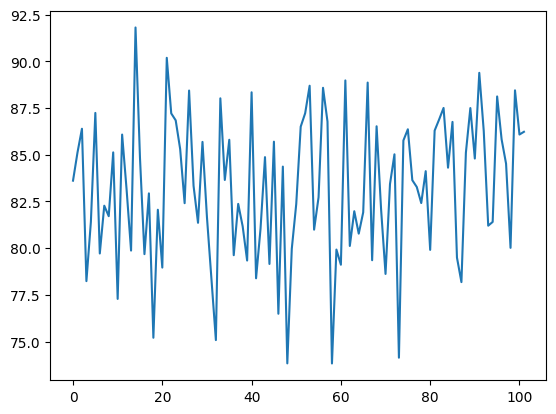

In [42]:
plt.plot([d[1] for d in data])